# CNN redes convolucionales Jorge Cueva - Cinthya Ramon

Durante esta práctica se busca utilizar el dataset de imagenes food101 de tensorflow datasets, para entrenar una red convolucional.
Objetivos:
- Realizar una introducción al dataset
- Realizar un un analisis exploratorio
- Desarrollar, entrenar y optimizar una red convolucional.
- Predecir nuevas imagenes.






El documento ahora, está compuesto en partes, cada una correspondiente a una de las órdenes de la práctica. seguido de la siguiente forma

## Índice

1. [Descripción del problema y dataset](#1-descripción-del-problema-y-dataset)  
2. [Análisis exploratorio](#2-análisis-exploratorio)  
3. [Red neuronal](#3-red-neuronal)  
   - [3.1 Desarrollo](#31-desarrollo)  
   - [3.2 Entrenamiento](#32-entrenamiento)  
   - [3.3 Optimización de la red](#33-optimización-de-la-red)  
4. [Evaluación con el conjunto de test](#4-evaluación-con-el-conjunto-de-test)  
5. [Predicciones](#5-predicciones)  
6. [Conclusiones](#6-conclusiones)  
7. [Referencias](#7-referencias)  

## 1. Descripción del problema y dataset

El dataset food101 está conformado por 101 categorías y 101000 imágenes. 

Para cada clase existen 1000 imagenes conformadas en 250 para pruebas y 750 para entrenamiento.

Todas las imágenes tienen un tamaño de 512 pixeles de ancho.

El link de información principal del dataset es el siguiente [Link del dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

### 1.1 Carga del dataset.

In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2 as cv
import os
from keras.models import Sequential
from keras.layers import Flatten, Dense
import numpy as np
from PIL import Image 


2025-06-08 21:24:12.415613: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 21:24:12.416106: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 21:24:12.419076: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 21:24:12.426762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749435852.440824  104723 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749435852.44

In [2]:

with open("food-101/meta/train.txt") as f:
    train_files = [os.path.join("food-101/images", line.strip() + ".jpg") for line in f]

with open("food-101/meta/test.txt") as f:
    test_files = [os.path.join("food-101/images", line.strip() + ".jpg") for line in f]


## 2. Análisis exploratorio

### 2.1 Información de los datos

El dataset cuenta con 101 clases de comida. 
El conjunto de datos, contiene 2 carpetas importantes, images, que contiene en subcarpetas todas imagenes de cada categoría, y meta, que contiene información para la configuración del dataset. clases y labels que son lo mismo con una sintaxis distinta, y el conjunto de test y train que indican cuales con los datos de entrenamiento y los de evaluación conforme la disposición del dataset 25% para pruebas y 75% para entrenamiento.

Tambien podemos ver las dimesiones de las imagenes, ya que todas tienen 512 de ancho, pero el alto varía.

### 2.2 Visualización de datos

Un solo dato

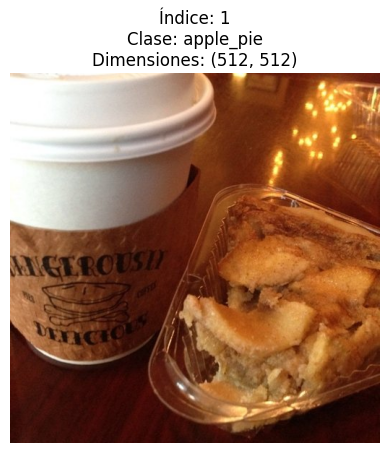

In [3]:
#obteniendolo directamente del sistema operativo.

index = 1  
image_path = train_files[index]
class_name = os.path.basename(os.path.dirname(image_path)) 
image = Image.open(image_path)



plt.imshow(image)
plt.axis('off')
plt.title(f"Índice: {index}\nClase: {class_name}\nDimensiones: {image.size}")
plt.show()

tfds.showExamples(), se encuentra en la documentación de tensorflow para visualización de datos. muestro entonces datos de entrenamiento y validacion (pruebas)

2025-06-08 21:26:34.711206: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


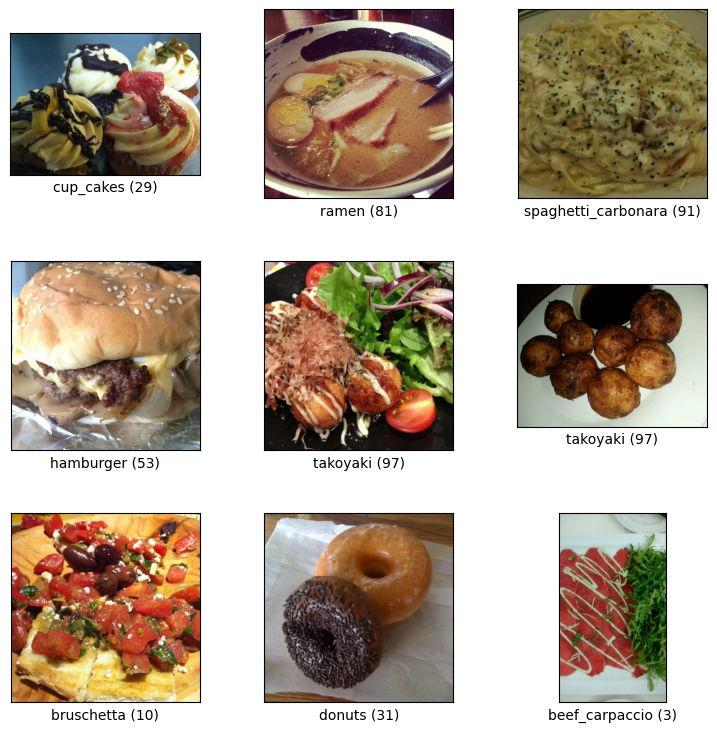

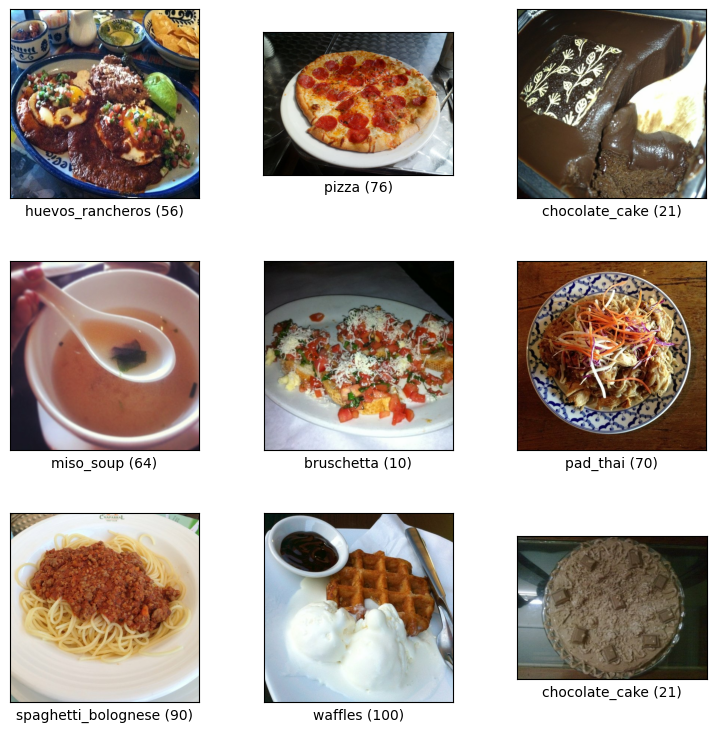

Imagenes de entrenamiento y pruebas


In [18]:
#Cargandolo y utilizando show_examples

builder = tfds.builder("food101", data_dir="food-101/")
builder.download_and_prepare()

ds_validation = builder.as_dataset(split="validation", as_supervised=True)
info_validation = builder.info
ds_train = builder.as_dataset(split="train", as_supervised=True)
info_train = builder.info


tfds.show_examples(ds_validation, info_validation)
tfds.show_examples(ds_train, info_train)
print("Imagenes de entrenamiento y pruebas")

(0) cup_cakes (382, 512, 3)


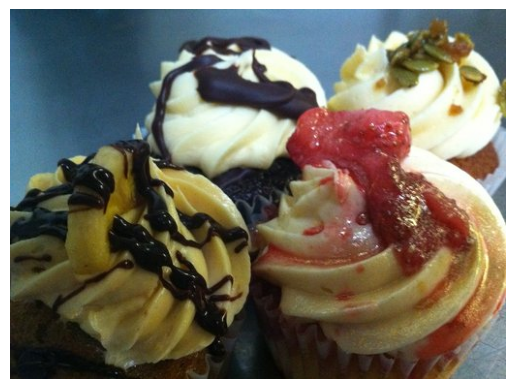


(0) huevos_rancheros (512, 512, 3)


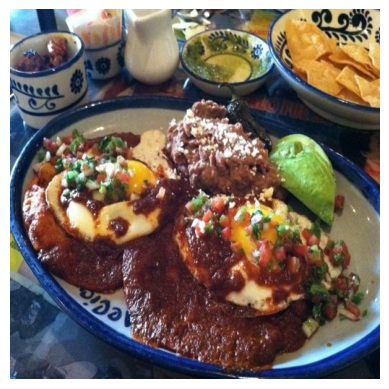

2025-06-08 21:24:27.275305: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
#Se utilizan los mismos dataset que antes, pero en un for que toma los que quiero
for i, (image, label) in enumerate(ds_validation.take(1)):
    print(f"({i}) {builder.info.features['label'].int2str(label)} {image.shape}") #Imprimo su posicion, label, y dimensiones
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print()
for i, (image, label) in enumerate(ds_train.take(1)):
    print(f"({i}) {builder.info.features['label'].int2str(label)} {image.shape}") #Imprimo su posicion, label, y dimensiones
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print()


## 3. Red Neuronal

Una vez que tenemos el dataset podemos empezar con el desarrollo de la red. utilizaremos para ello:


### 3.0.1 Preparación del dataset.

Dado que las imagenes del dataset se encuentran en dimensiones distintas, lo primero va a ser tener que rehacerlas en un tamaño fijo. 
y cómo se va a tener que hacer con todas, definimos funcion y la comprobamos

In [35]:

def resizeImg(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (100,100))
    return image, label


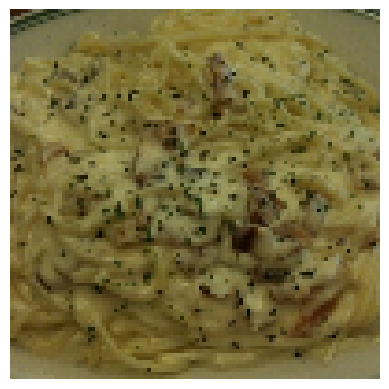

In [37]:
# y comprobamos con una que sepamos tiene otra forma, como la de cupcakes que tiene un tamaño de 382,512
imagen, label = next(iter(ds_validation.take(1)))

img, label = resizeImg(image, label)
plt.imshow(img)
plt.axis("off")
plt.show()
print()


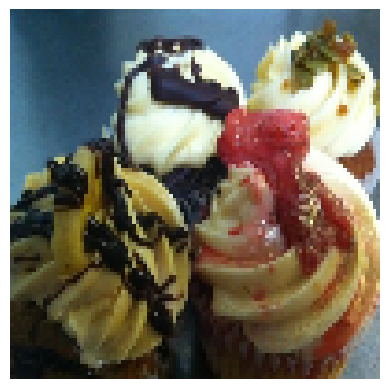

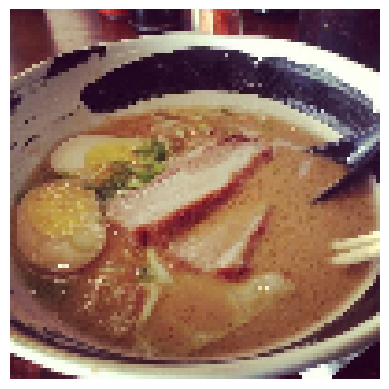

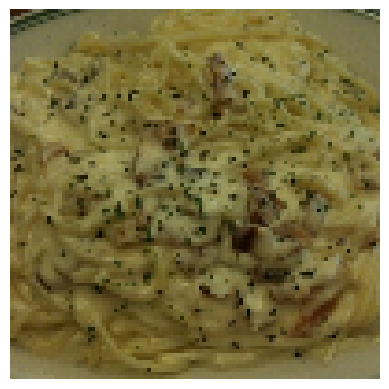

In [42]:
#Rehacemos los datasets de entrenamiento y pruebas y comprobamos que funcione bien

ds_validation = ds_validation.map(resizeImg)
ds_train = ds_train.map(resizeImg)

for i, (image, label) in enumerate(ds_validation.take(3)):
    print()
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print()

###     3.1 Desarrollo

In [38]:
imagen,label = next(iter(ds_train.take(1)))
shape = np.prod(image.shape)
print(imagen.shape)
print(shape)
    
model = Sequential()
model.add(Flatten(input_shape=image.shape))# agrego una capa sin funcion de activacion que será el input de las imagenes
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))   
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
#en la última capa tiene que haber tantas neuronas como clases haya, en este caso 10
model.add(Dense(101, activation='softmax'))

#compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



(512, 100, 100, 3)
30000


### 3.2 Entrenamiento

In [46]:
epocas = 50
batch_size = 512


history = model.fit(ds_train, epochs=epocas, verbose=1)


Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.0750 - loss: 4.1111
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.0767 - loss: 4.0868
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.0777 - loss: 4.0755
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.0801 - loss: 4.0555
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0780 - loss: 4.0594
Epoch 6/50
 25/148 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.0780 - loss: 4.0681

KeyboardInterrupt: 

dict_keys(['accuracy', 'loss'])


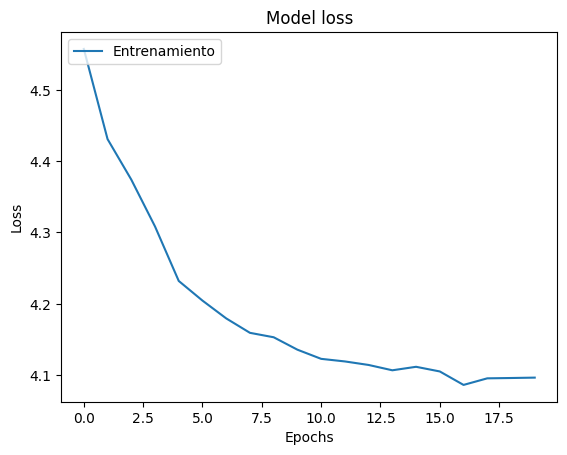

In [40]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento'], loc='upper left')
#plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [45]:
ds_validation = ds_validation.map(resizeImg).batch(batch_size).prefetch(tf.data.AUTOTUNE)


model.evaluate(ds_validation,verbose=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.0638 - loss: 4.1935


[4.203343868255615, 0.06336633861064911]

### 3.3 Optimización de la red

## 4. Evaluación con el conjunto de test

## 5. Predicciones

## 6. Conclusiones

## 7. Referencias